<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/data_analysis/torch_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/My Drive/CARD_SPENDING_RESIDENT.csv", sep="\t")

jung = df[df.GU_CD == 140]
nowon = df[df.GU_CD == 350]

jung2019 = jung[jung.STD_DD < 20190528]

data = jung2019[jung2019.MCT_CAT_CD == 81] # 음료 식품 카테고리

data = data.groupby('STD_DD').sum()[['USE_CNT','USE_AMT']].reset_index()

# normalization
cnt_mean = data.USE_CNT.mean()
cnt_std = data.USE_CNT.std()
data.USE_CNT = (data.USE_CNT - cnt_mean)/cnt_std

amt_mean = data.USE_AMT.mean()
amt_std = data.USE_AMT.std()
data.USE_AMT = (data.USE_AMT - amt_mean)/amt_std

amt_X, amt_y = [], []
cnt_X, cnt_y = [], []
for i in range(89):
    amt_X.append(data.USE_AMT[i:i+20].values)
    amt_y.append(data.USE_AMT[i+20:i+27].values)
    cnt_X.append(data.USE_CNT[i:i+20].values)
    # cnt_y.append(data.USE_CNT[i+20:i+27].values)

amt_X = np.array(amt_X)
amt_y = np.array(amt_y)
cnt_X = np.array(cnt_X)
# cnt_y = np.array(cnt_y)

X = np.concatenate([amt_X.reshape(-1, 20, 1), cnt_X.reshape(-1, 20, 1)], axis=2)
y = amt_y

X.shape, amt_y.shape

((89, 20, 2), (89, 7))

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
# valid_cycle_x = torch.FloatTensor(valid_cycle_x).to(device)
# valid_cycle_y = torch.FloatTensor(valid_cycle_y).to(device)

class LSTMModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size):
        # time model
        super(LSTMModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # merge model
        self.time_fc = nn.Sequential(
            nn.Linear(hidden_size, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )
        
    def forward(self, x_time):
        # time part
        hidden = (
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        )
        
        out, _ = self.lstm(x_time, hidden)
        out = out[:, -1, :] # LSTM의 output은 모든 출력값인데 마지막 값만 받는다.
        out = self.time_fc(out.view(-1, self.hidden_size)) # 3 -> 2차원
        
        return out

In [42]:
#hidden state : 전달과정 중간 출력의 차원
model_trend = LSTMModel_trend(input_size = 2, hidden_size = 32).to(device)

In [43]:
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [44]:
# Train model
num_epochs  = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

for t in range(num_epochs):
    pred = model_trend(X)
    loss = criterion(pred, y)

    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  10 MSE:  0.7402269244194031
Epoch  20 MSE:  0.6386284828186035
Epoch  30 MSE:  0.5172756910324097
Epoch  40 MSE:  0.42804139852523804
Epoch  50 MSE:  0.36373332142829895
Epoch  60 MSE:  0.330120712518692
Epoch  70 MSE:  0.31860455870628357
Epoch  80 MSE:  0.29089775681495667
Epoch  90 MSE:  0.2721436023712158
Epoch  100 MSE:  0.2613256275653839
Epoch  110 MSE:  0.24674035608768463
Epoch  120 MSE:  0.23900997638702393
Epoch  130 MSE:  0.21800075471401215
Epoch  140 MSE:  0.20518620312213898
Epoch  150 MSE:  0.19518445432186127
Epoch  160 MSE:  0.18152394890785217
Epoch  170 MSE:  0.17196738719940186
Epoch  180 MSE:  0.16395464539527893
Epoch  190 MSE:  0.15389424562454224


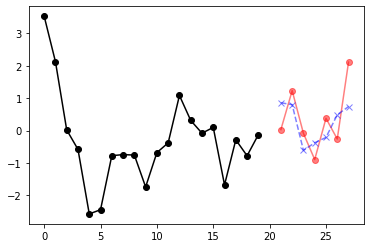

In [49]:
plt.plot(np.arange(20), X.cpu().detach().numpy()[i,:,0],
             marker = 'o', color = 'black', label = 'True_input')
plt.plot(np.arange(21,28), y.cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
plt.plot(np.arange(21,28), pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)

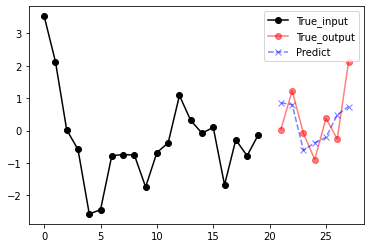

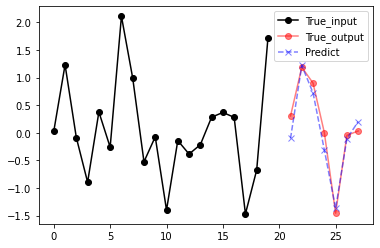

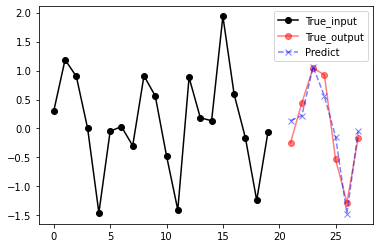

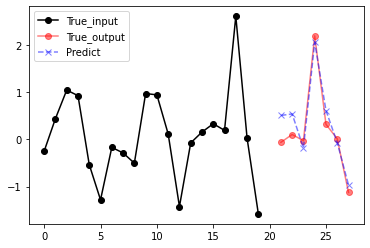

In [51]:
import matplotlib.pyplot as plt

for i in range(4):
    i = i*20
    plt.plot(np.arange(20), X.cpu().detach().numpy()[i,:,0],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28), y.cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28), pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    plt.legend()
    plt.show()